In [11]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  

In [12]:
#Setup the display

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [13]:
# Make DQN object

class DQN(nn.Module):
    def __init__(self,height,width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=height*width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    def forward(self,x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x


In [14]:
#For replay memory, we use named tuple for storing info : maps field to values
from collections import namedtuple
Replay_exp = namedtuple('experience',('state','action','next_state', 'reward'))
e = Replay_exp(2,1,4,5)
e

experience(state=2, action=1, next_state=4, reward=5)

In [15]:
#Replay memory object
class ReplayMemory():
    def __init__(self,size):
        self.size = size
        self.memory = []
        self.no_exp = 0
        
    #To add exerience in memory
    def push(self, Replay_exp):
        if len(self.memory)<self.size:
            self.memory.append(Replay_exp)
        else:
            #remove the most previous experience
            self.memory[self.no_exp % self.size] = Replay_exp
        self.no_exp+=1
    #sample experiences
    def sample(self,batch_size):
        return random.sample(self.memory, batch_size)
    def make_sample(self,batch_size):
        return batch_size<=len(self.memory)


In [16]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)

In [17]:
#Create agent
class Agent():
    def __init__(self,strategy,no_actions,device):
        self.strategy = strategy
        self.no_actions = no_actions
        self.current_step = 0
        self.device = device
    def action(self, state, policy_nw):
        self.current_step+=1
        rate = self.strategy.get_exploration_rate(self.current_step)
        
        if rate>random.random():
            action =  random.randrange(self.no_actions)
            #print('type1: ',type(torch.tensor([action]).to(self.device)))
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                #print('type2: ',type(torch.tensor(policy_nw(state).argmax(dim=1).item())))
                return torch.tensor([policy_nw(state).argmax(dim=1).item()])

In [18]:
class CartPoleManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):  
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)



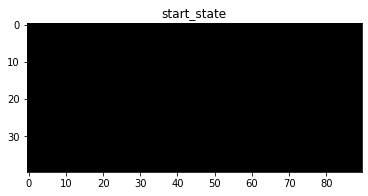

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleManager(device)
em.reset()
screen = em.render('rgb_array')

#Starting state visualization
screen = em.get_state()
    
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('start_state')
plt.show()
em.close()

In [20]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [21]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [22]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Replay_exp(*zip(*experiences))
    #print('Batch action: ',batch.action,"----------")
    t1 = torch.stack(batch.state, dim=0)
    t2 = torch.stack(batch.action, dim=0)
    t3 = torch.stack(batch.reward, dim=0)
    t4 = torch.stack(batch.next_state, dim=0)
    #print(t1,'||',t2,"||",t3,"||",t4)
    return (t1,t2,t3,t4)

e1 = Replay_exp(1,1,1,1)
e2 = Replay_exp(2,2,2,2)
e3 = Replay_exp(3,3,3,3)

experiences = torch.tensor([e1,e2,e3])
print(experiences)
batch = extract_tensors(experiences)
print(batch)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])
(tensor([1, 2, 3]), tensor([1, 2, 3]), tensor([1, 2, 3]), tensor([1, 2, 3]))


In [23]:
#hyper-parameters

batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em = CartPoleManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_nw = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_nw = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

#copy weights into targets
target_nw.load_state_dict(policy_nw.state_dict())
#target n/w not in training mode
target_nw.eval()
optimizer = optim.Adam(params=policy_nw.parameters(), lr=lr)

In [25]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        print('states: ',policy_net(states).shape)
        print('actions: ',actions.shape)
#         print('actions: ',actions.unsqueeze(-1)[0])
#         print('result: ',policy_net(states).gather(dim=1, index=actions))
        return policy_net(states).gather(dim=1, index=actions) 
        

    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [28]:
# import warnings 
# warnings.filterwarnings('ignore')

In [ ]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = agent.action(state, policy_nw)
        #print('tiemstep',timestep,'action',action)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Replay_exp(state, action, next_state, reward))
        state = next_state
        
        if memory.make_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            current_qvalues = QValues.get_current(policy_nw, states, actions)
            next_qvalues = QValues.get_next(target_nw, next_states)
            target_qvalues = rewards + gamma*next_qvalues
            
            
            loss = F.mse_loss(current_qvalues, target_qvalues.unsqueeze(1))
            #to remove the gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    if episode % target_update == 0:
        target_nw.load_state_dict(policy_nw.state_dict())

em.close()          
     

states:  torch.Size([256, 2])
actions:  torch.Size([256, 1])


/home/zeus/venv1/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([256, 1, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


In [30]:
#Working of gather
#dim=1 is referring to columns
import torch
import random
t = torch.arange(50).reshape((5,10))
a = torch.tensor([1,2,1,1,1]).reshape((5,1))
print(t.shape)
print(a.shape)
print(t)
print(a)
torch.gather(t, 1, a)

torch.Size([5, 10])
torch.Size([5, 1])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])
tensor([[1],
        [2],
        [1],
        [1],
        [1]])


tensor([[ 1],
        [12],
        [21],
        [31],
        [41]])